## Library import

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets # UI 라이브러리 함수를 전달하면, 셀렉트 박스나 슬라이더 조작으로 인수를 변경하면서 함수 실행 가능
import IPython.display as display
from ipywidgets import Layout, Button, Box, Layout, Image, IntSlider, AppLayout

## Data check

In [67]:
img = cv2.imread('./data/FHD/fhd_40.jpg')

In [68]:
height,width = img.shape[:2] # 1080 , 1920

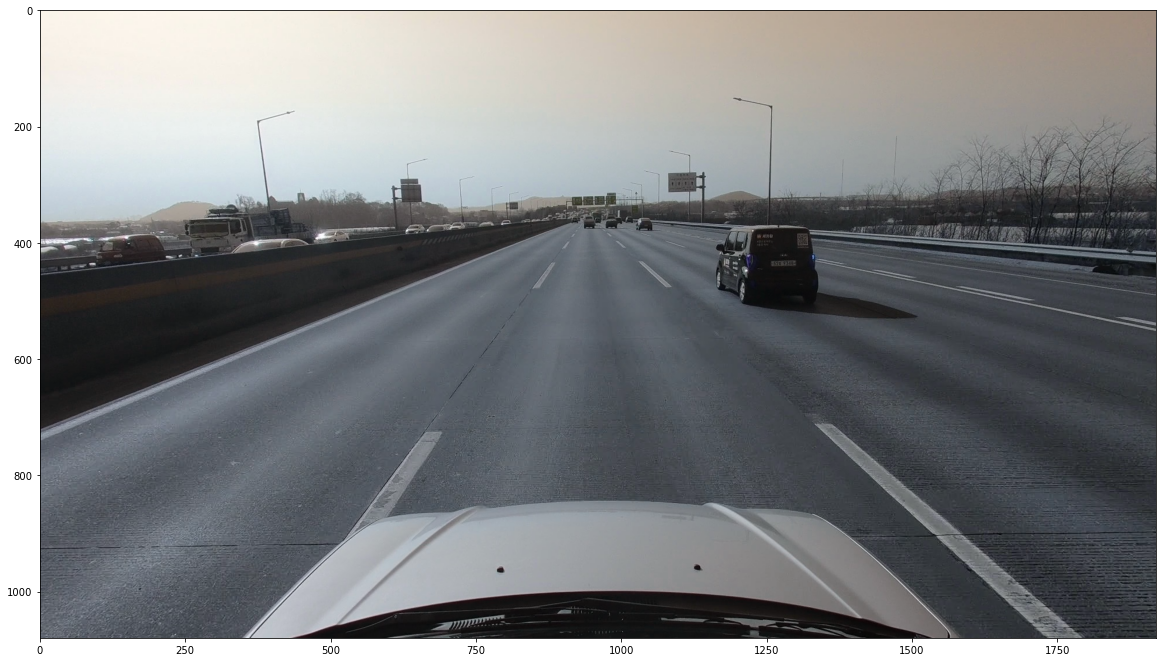

In [69]:
plt.figure(figsize=(20,20))
plt.imshow(img)

# Edge Detection

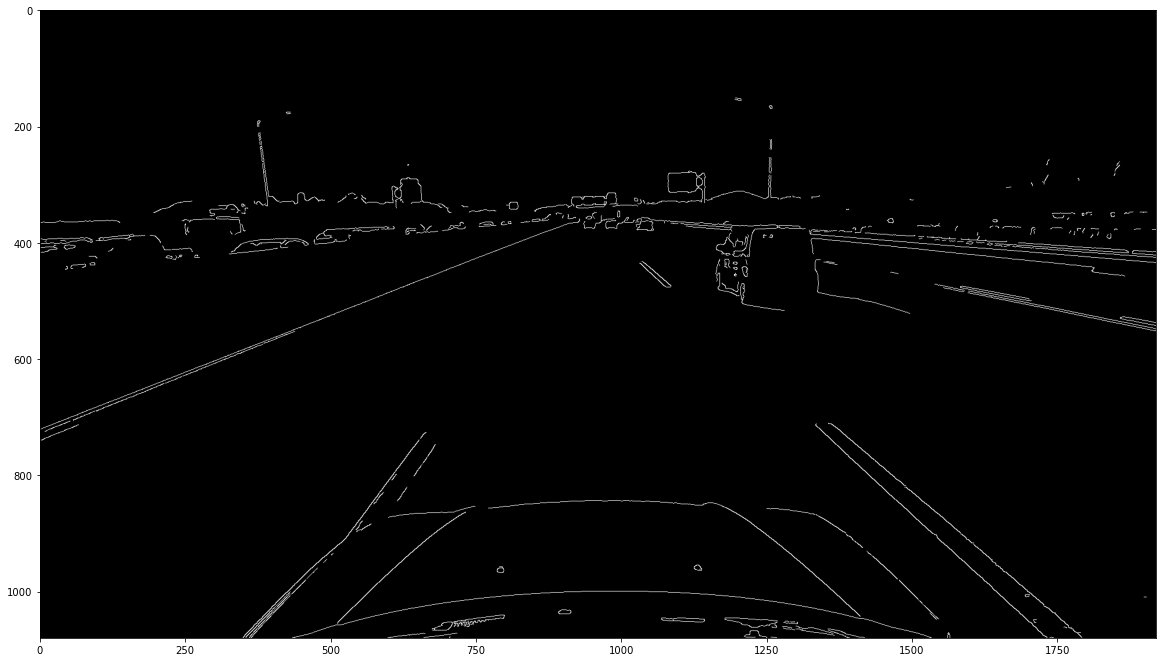

In [71]:
lane_image = np.copy(img)

# Edge Detection
def canny(image):
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    blur = cv2.medianBlur(gray,5)
    canny = cv2.Canny(blur,130,200,3)
    return canny

# 결과 확인
canny_image = canny(lane_image)
plt.figure(figsize=(20,20))
plt.imshow(canny_image, cmap='gray')

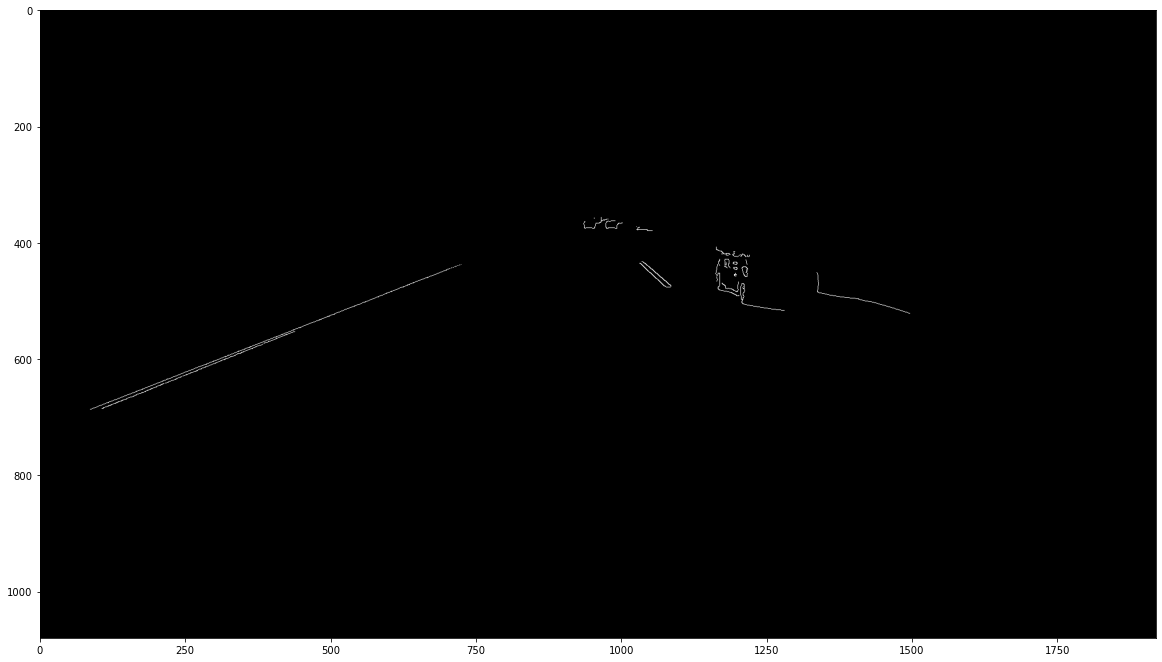

In [72]:
#관심영역 지정
def region_of_interest(image):
    height = image.shape[0]
    triangle = np.array([[(0,690),(1920,600),(960,355)]])
    mask = np.zeros_like(image)
    cv2.fillPoly(mask,triangle,255)
    masked_image = cv2.bitwise_and(image,mask)
    return masked_image

# 결과 확인
cropped_image = region_of_interest(canny_image)
plt.figure(figsize=(20,20))
plt.imshow(cropped_image, cmap='gray')

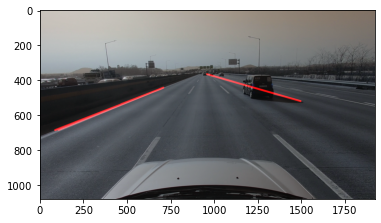

In [73]:
def display_lines(image,lines):
    line_image = np.zeros_like(image)
    if lines is not None:
        for line in lines:
            try:
                x1,y1,x2,y2 = line
            except:
                x1,y1,x2,y2 = line[0]
                
            cv2.line(line_image,(x2,y2),(x1,y1),(255,0,0),10)
    return line_image
    
lines = cv2.HoughLinesP(cropped_image,2,np.pi/180,100,np.array([]),minLineLength=10,maxLineGap=300) # (x1,y1,x2,y2) <- 더 원점에 가까운 점이 x1,y1됨
# maxLineGap : 선으로 판단한 최대간격 , 라인사이 갭
# minLineLength : 선으로 인정할 최소 길이 
result_line = []

for i in range(0,len(lines)):
    result_line.append(lines[i])
    
line_image = display_lines(lane_image,lines)
combo_image = cv2.addWeighted(lane_image,0.8,line_image,1,1)


# 결과 확인
plt.imshow(combo_image)

In [75]:
# 가장 바깥쪽에 있는 선 찾기 

min_idx_candidate=lines.argmin(axis=0)[0][0::2]
min_idx = 0 
if lines[min_idx_candidate[0]][0][0] <= lines[min_idx_candidate[1]][0][0]:
    min_idx= min_idx_candidate[0]
else:
    min_idx = min_idx_candidate[1]

max_idx_candidate=lines.argmax(axis=0)[0][0::2]
max_idx=0

if lines[max_idx_candidate[0]][0][0] <= lines[max_idx_candidate[1]][0][0]:
    max_idx = max_idx_candidate[0]
else:
    max_idx = max_idx_candidate[1]

In [76]:
min_idx,max_idx

(3, 4)

In [77]:
class Line :
    """
    투시변환할 부분을 찾아주는 class
    """
    def __init__(self, data1, data2):
   
        self.line1 = data1
        self.line2 = data2
        #print(self.line1)
    def slope(self):
        (x1, y1), (x2, y2) = self.line1
        (x3, y3), (x4, y4) = self.line2
        
        if (y2-y1) == 0 :
            #print('Ys are equal, m1 = 0')
            m1 = 0
        else:
            m1 = (float(y2)-y1)/(float(x2)-x1)
        
        if (y4-y3) == 0 :
            #print('Ys are equal, m2 = 0')
            m2 = 0
        else:
            m2 = (float(y4)-y3)/(float(x4)-x3)
            
        return m1, m2
                    
    def yintercept(self, m1, m2):
        (x1, y1), (x2, y2) = self.line1
        (x3, y3), (x4, y4) = self.line2
        
        if m1 != 0 :
            b1 = y1 - m1*x1
        else :
            b1 = y1
            
        if m2 != 0 :
            b2 = y4 - m2*x4
            
        else: b2 = y4
        
        return b1, b2
    
    def findIntersect(self, m1,m2, b1, b2):
        
        if m1 != 0 | m2 != 0 :
            px = (b2-b1) / (m1-m2)
            py = (b2*m1 - b1*m2)/(m1-m2)
        elif m1 == 0 :
            px = (b1-b2)/m2
            py = b1
        elif m2 == 0 : 
            px = (b2-b1)/m1
            py = b2 
        else :  print('No points')
        
        return px, py
        

class IMP:
    """
    투시변환 실시하여 전경이미지 -> 정사영으로 변환해주는 class
    """
    def __init__(self, img):
        
        #import cv2
        #img = cv2.imread('c:/OpenCV/image-003.jpeg')     
        self.img = img
        
        #self.topHeight = 565
        #self.height, self.width = 1080, 1920
        
    def impTransformer(self,left,right):  
        
        import numpy as np
        import cv2 
        

        # 정사영 파라미터 변환 
        topHeight = 545
        height, width = self.img.shape[:2]
        up =  [(0, topHeight), (width+1000, topHeight)]
        down =  [(-10000,height), (width+100000, height)]     
        
               
        leftup = Line(left, up)
        leftdown = Line(left, down)
        rightup = Line(right, up)
        rightdown = Line(right, down)
        m1, m2 = leftup.slope()
        b1, b2 = leftup.yintercept(m1,m2)
        p1x, p1y = leftup.findIntersect(m1,m2,b1,b2)
        
        #print('point1 : ', p1x, p1y)
        
       
        
        m1, m2 = leftdown.slope()
        b1, b2 = leftdown.yintercept(m1,m2)
        p2x, p2y = leftdown.findIntersect(m1,m2,b1,b2)
        #print('point2 : ', p2x, p2y)
        
       
        
        m1, m2 = rightup.slope()
        b1, b2 = rightup.yintercept(m1,m2)
        p3x, p3y = rightup.findIntersect(m1,m2,b1,b2)
        #print('point3 : ', p3x, p3y)
        
        m1, m2 = rightdown.slope()
        b1, b2 = rightdown.yintercept(m1,m2)
        p4x, p4y = leftup.findIntersect(m1,m2,b1,b2)
        #print('point4 : ', p4x, p4y)
        

        dst = np.array([[0,0], [0, height], [width,0], [width,height]], dtype=np.float32)
        src = np.array([ [p1x,p1y], [p2x,p2y], [p3x,p3y], [p4x,p4y]], dtype=np.float32)
        mtrx = cv2.getPerspectiveTransform(src, dst)
        
        transformedFHD = cv2.warpPerspective(self.img, mtrx, (width,height))
        ##  C++코드에서 정사영 자체는 원본 사이즈로 생성,  ( 1080, 560 ) -> (1080,1920)
        outimg = cv2.resize(transformedFHD,dsize=(960,540))
        
        return outimg

In [78]:
left = [tuple(lines[min_idx][0][0:2]),tuple(lines[min_idx][0][2:])]
right = [tuple(lines[max_idx][0][0:2]),tuple(lines[max_idx][0][2:])]

In [79]:
left

[(86, 686), (319, 596)]

In [80]:
right

[(956, 366), (1493, 520)]

In [81]:
## transformation frame
curr_frame = IMP(img)   
curr_outimg = curr_frame.impTransformer(left,right) # 이미지 정사영 변환
curr_cropimg = curr_outimg[0:250, 0:960] # 위에 있는 도로만 사용 -> (250, 1080)
curr_cropimg = cv2.rotate(curr_cropimg, cv2.ROTATE_90_CLOCKWISE) # 시계방향으로 90도 회전 (1080, 250)
#result.append(curr_cropimg)

In [82]:
cv2.imwrite('test5.jpg', curr_cropimg)

True

In [83]:
cv2.imshow('out_image',curr_cropimg)
cv2.waitKey()
cv2.destroyAllWindows()

In [84]:
img1 = cv2.imread('test1.jpg')
img2= cv2.imread('test2.jpg')
img3 = cv2.imread('test3.jpg')

In [86]:
import Stitching

In [87]:
imageList = [img1,img2,img3]

In [88]:
stitcher = Stitching.Stitcher(imageList)
panorama = stitcher.Stacking(start=0,stop=3)

In [89]:
# save panorama
cv2.imwrite("t_panorama.jpg",panorama)

True